# Generate, Propagate, and Edit Fish Segmentation Masks

This notebook is meant for creating segmentation masks of the fish from the fishway videos. The mask for a single frame is generated by providing click prompts to the Segment Anything Model (SAM2). This mask is then forward and backward propagated through the video to create a complete masked track of the fish, or multiple fishes, through the video. Then the masks can be edited using a drawing tool to add missing parts of the fish to the mask or to remove any background that was incorporated into the mask. The masks are saved to a json file in COCO label format.

## Load Libraries

The code in this section loads the required libraries and the functions from the labelling_functions.py file. You should not need to edit any of these cells, just run them as is.

In [1]:
import sys
import os

# Add the directory of the .py file to the path (only needed once at top)
sys.path.append(os.getcwd())
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [ ]:
import importlib
import numpy as np
import torch
import json
from tqdm import tqdm
from pathlib import Path
import labelling_functions
from matplotlib import pyplot as plt
from IPython.display import Video

In [47]:
## Run this cell to reload functions from labelling_functions.py after editing --------------
importlib.reload(labelling_functions)
import labelling_functions

## Select a Video to Label

The cell below will select a random video from the fishway dataset to be labelled. It will check the `tracking_json` file to make sure that the video has not already been labelled. If you would like to select a specific video to label or draw a video from a specific directory then you can input the video or directory path as the `specific_path` variable in the cell below.

In [ ]:
# Setup paths
base_video_dir = Path("/Users/simone/Documents/UofT MSc/LOMU_Fishway_Data/RiverWatcher/test") #path to where all the fishway videos are stored
tracking_json = Path("/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/video_tracking.json") #path to the json file that tracks which videos have been labelled
labelled_data_dir = Path("/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data") #path to where the labelled data is stored
#specific_path = Path("path/to/specific/video/or/folder/to/check/for/unlabelled/videos") #change to the specific path you want to check if you don't want to select a random video

# Get video for labeling
video_path = labelling_functions.select_unlabeled_video(
    base_dir=base_video_dir,
    #specific_path=specific_path,
    tracking_json_path=tracking_json,
    random_select=True # Set to False to select the first video in the directory
)

Selected video: /Users/simone/Documents/UofT MSc/LOMU_Fishway_Data/RiverWatcher/test/Ganaraska/10012024-10072024/24  10  01  11  32/421.mp4


When run, the cell below will output the video that was chosen above. Watch the video to see if you want to label it (more details below). Make note of whether the fish leaves the camera view and reappears as this will be important when propagating the masks.

In [ ]:
# Play selected video
Video(str(video_path), embed=True)

The cell below will let you choose whether or not you want to label the selected video. The chane that you need to make to the cell below is to replace the name that comes after the `labeler_name` argument with your name. Then run the cell and it will give a pop up window at the top of VS Code that will ask you *"Do you want to label this video? (y/n/s): "*. 
* If you watched the video above it is too hard to make out the fishes due to turbid water or low lighting then this is probably not a video we want to label as it will be too difficult. In this case, type `s` and press enter to skip this video. Then it will prompt you with *"Enter reason for skipping: "*. Write a little note that explains why this video shouldn't be lablled by anyone, for example, "Dark" or "Turbid" or "Blocked camera". Make sure you write the comment in quotation marks and then press enter when you are done. This will update the `tracking_json` file for everyone so that we all know this video should be skipped and why. The function that picks a random video from the dataset will skip over this video now. Go back to the first cell in this section to select a new video.

* If you watched the video and you decided you don't want to label it right now (for example you are looking to label a specifc species), but someone could label it at some point then type `n` and press enter. This will not update the `tracking_json`. Go back to the first cell in this section to select a new video.

* If you watched the video and decided you do want to label the video, then type `y` and press enter. This will update the `tracking_json` to show that the labelling of this video is `in_progress` and it will add your name to the `labeler_name`. Then it will create a new directory which is named after the file path of the video. Inside this folder there are two folders: `images` which contains the frames extracted from the video as jpeg images, and `annotations` which contains a json file called `instances_default.json` which will be used to store the masks that will be created later in this notebook.

In [ ]:
# Confirm whether to label the video
if labelling_functions.confirm_video_for_labeling(
    video_path=video_path,
    tracking_json_path=tracking_json,
    labeler_name="Simone" # Replace with your name
):
    new_folder_path = labelling_functions.create_labelled_video_dir(label_dir=labelled_data_dir, video_path=video_path)
    images_path = new_folder_path / "images"
    labelling_functions.extract_frames_ffmpeg(video_path, images_path)
    annotations_path = Path(new_folder_path / "annotations")
    annotations_path.mkdir(parents=True, exist_ok=True)
    # Path to save the JSON file
    json_path = annotations_path / "instances_default.json"
    # Create COCO JSON
    coco = labelling_functions.create_coco_json(images_path, json_path)
else:
    print("Video was not selected for labelling... select another video to label")

Invalid input. Please enter 'y' for yes, 'n' for no, or 's' for skip (too difficult)
Video skipped - select another video to label


## Set Up Segment Anything Model (SAM2)

The code in this section sets up the model for running inference on the chosen video. The jpeg frames are added to the inference state and this inference state is used and continuously updated when generating or propagating masks. You do not need to edit any of the cells in this section, just run them all as is.

In [9]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )
elif device.type == "cpu":
    torch.autocast("cpu", dtype=torch.bfloat16).__enter__()

#torch.set_float32_matmul_precision('high')

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [10]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/checkpoints/sam2.1_hiera_large.pt" # Change this to the path of your SAM2 checkpoint (see README for details)
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [11]:
# Load the video and initialize the predictor... create inference state
inference_state = predictor.init_state(video_path=str(images_path))

frame loading (JPEG): 100%|██████████| 152/152 [00:04<00:00, 36.86it/s]


## Generate and Propagate Masks

If you ever want to reset the inference state and the json file that stores the labels so that you can start over labelling the video then uncomment the last two lines of the cell below and run it.

In [ ]:
## Reset the inference state and coco JSON (only needed if you make a mistake when annotating and want to start over)
# predictor.reset_state(inference_state)
# coco = labelling_functions.create_coco_json(images_path, json_path)

The cell below will output a widget that allows you to create and propagate masks of fish throughout the video. See the labelling instructions PDF for guidelines about how the masks should look. Here is the recommended workflow with information about how to work with multiple fish in the next paragraph:


1. Find the first frame and last frame that contain a part of the fish. For example, if part of the fish's tail is in the frame titled 00113.jpg and then frame 00114.jpg is empty then 113 is the last frame the fish is in. Make note of the first and last frame numbers as you will need these numbers later. You can change the `start_frame` argument in the cell below to quickly jump around the video instead of flipping through each frame. 

2. Find a frame of the video where all of the fish is clearly visible, particularily any fins that may not show up well on parts of the background. If this isn't possible then go with what you think is the best frame.

3. Select the `Species` from the dropdown menu and ensure the `Track ID` is set to 1 (each fish in a video has a unique track ID).

4. Click on the fish and its fins to add positive clicks which indicate where the fish is. Right click in areas around the fish to add negative clicks that indicate areas where the fish is not, particularily in areas that may be mistaken to be part of the fish (i.e. between two fins, in areas where contrast is low around fish boundary). You can left/right click on a positive/negative click that you've added to remove it. 

5. Click the `Generate Mask` button to create the mask based on the clicks you just added. The mask will be overlayed on the frame of the fish. You can click the `Show Clicks` button to stop displaying the clicks if you would like to see the mask more clearly.

6. If you are not happy with some areas of the mask, you can add more positive and negative clicks in these areas and regenerate the mask. The previous clicks you added will still be used to generate the mask. If you would like to go back to a previous mask you generated you can click `Undo Mask`.

7. Once you are happy with the mask, you can enter the last frame index number that you noted in step 1 to the `Target Frame` text box. Then click the `Propagate Mask` button. This will propagate the mask forward through the video and should output a progress tracker above the plot so you can see if it is working.

8. Once the forward propagation is complete, you can flip to the next few frames to see if the propagation worked okay. Then flip back to the frame that you first created the mask on. Enter the first frame that you noted in step 1 to the `Target Frame` text box and then click the `Propagate Mask` button to propagate the mask backward through the video.

9. Once the backward propagation is complete and you have confirmed that it worked okay by looking at a few previous frames then you can click the `Save JSON` button. This will add the annotations to the coco json that was created at the beginning of the notebook.


Here are some notes about working with videos that have multiple fish and other edge cases:


* When adding clicks, make sure you have selected the correct species for the fish you are clicking on and make sure that each fish is assigned its own `Track ID`.

* If you can find a frame that has clear visibility of all the fish, then you can generate masks for all the fish at once after providing clicks. Then, you can propagate the masks in the same way described above, using the first/last frames as the ones that are the first/last to contain part of any of the fish. 

* If you cannot find a frame that has clear visibility of all the fish, then you can track each fish individially. That is, you do all the steps above, ignoring the other fish (the first and last frames when propagating should be the frames that contain the fish you are tracking not the other fish).

* The `Undo Button` will only undo the mask of the spcies and `Track ID` that is currently selected in the UI, not all the masks for the current frame.

* The `Delete Annotation` button should be used when you have created an annotation for a fish that is the wrong species or is not there at all. 

* If you make a mistake when annotating, for example you assign the wrong species, or generate a mask on the background, it is best to reset the inference state so that the clicks and masks are removed from the model. You can do this by running the cell that is commented out just above this paragraph. This will also reset the the coco json file and coco object so that all annotation will be removed. 

* If a fish completely leaves the view of the camera and then reenters the view, then only assign the fish the same `Track ID` if:
    * You are confident it is the same fish (based on species, size, angle of reentry, movement pattern).
    * The fish reenters in roughly the same location it left by.
    * There is not more than 1 other fish in the video. 
    * The fish is not out of view for more than 3 seconds (you can check the time stamp for each frame at the top of the video).


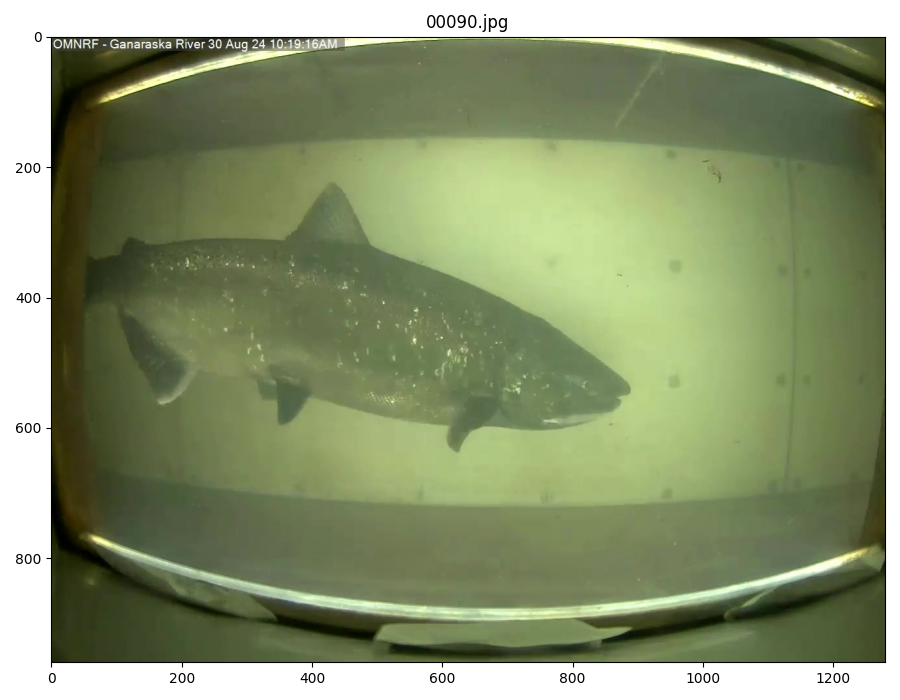

In [ ]:
# This cell displays the ImageAnnotationWidget for annotating the video frames
# The only thing you need to change is the start_frame parameter if you want to jump around the video quickly to decide where to start
%matplotlib widget
from labelling_functions import ImageAnnotationWidget

# Clean up any existing widget
if 'widget' in locals():
    plt.close(widget.fig)
    del widget

# Initialize widget
widget1 = ImageAnnotationWidget(
    coco_dict=coco,
    image_dir=images_path,
    start_frame=90,
    predictor=predictor,
    inference_state=inference_state,
    output_json_path=json_path,
)

## Edit Masks Using Drawing Widget

This widget allows you to edit the masks that were created above. You can draw in or erase areas of the mask. You can choose whether to draw using the lasso tool or the polygon tool. Try out both to see which you prefer. The Smooth Mask button will get rid of small floating points and interior holes withing the mask. The undo button will undo the last edit you made to the displayed frame, whether that is drawing, erasing, or smoothing the mask. To zoom in to the image, click the Zoom In button and then click on the area of the plot you want to zoom into. If there are multiple fish in the frame, you can choose which mask you want to edit using the dropdown menu. The Save JSON button will save the edited masks to a new COCO JSON file. 

In [62]:
## Run this cell to reload functions from labelling_functions.py after editing --------------
importlib.reload(labelling_functions)
import labelling_functions

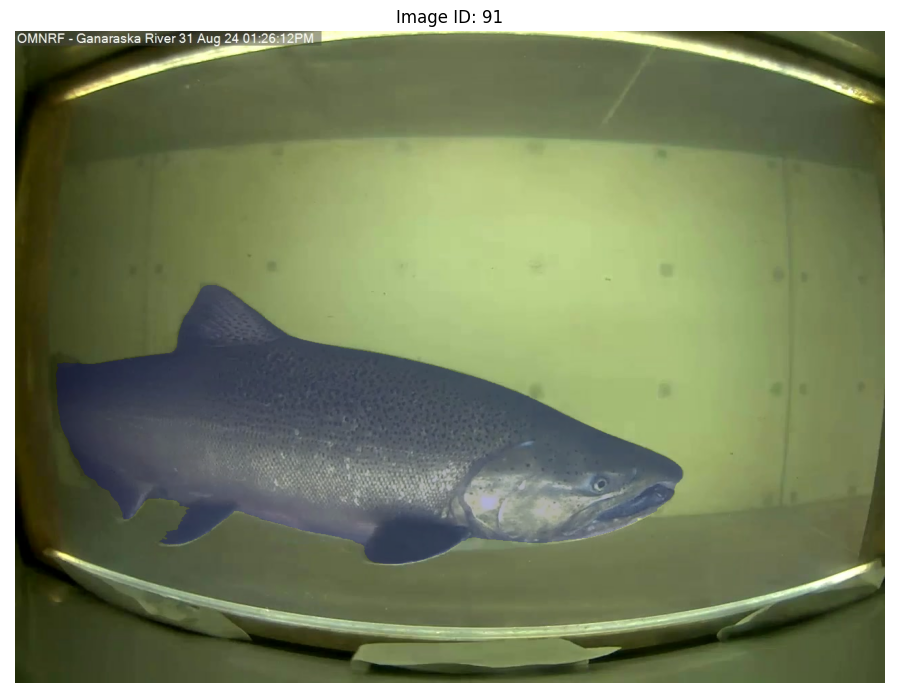

In [63]:
from labelling_functions import MaskEditor
widget2 = MaskEditor(coco_json_path=json_path, frames_dir=images_path, start_frame=90)

## Extra Code/Testing Area (ignore)

In [43]:
fishway_annotations = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data"
output_ytvis_path = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/ytvis_fishway.json"
labelling_functions.convert_all_coco_to_ytvis(fishway_annotations, output_ytvis_path)

YTVIS JSON saved to /Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/ytvis_fishway.json


In [27]:
edited_json_path = annotations_path / f"edited_{json_path.name}"
with open(edited_json_path) as f:
    edited_coco = json.load(f)

In [48]:
## Save updated segmentations to new JSON file
updated_json_path = annotations_path / f"updated_{json_path.name}"

with open(updated_json_path, "w") as f:
    json.dump(coco_propagated, f, indent=2)